### 0. Я собрал собственный датасет с сайта gipernn по продаже квартир, по которому в дальнейшем будет проводиться машинное обучения (датасет обновляется периодически, поэтому количество данных там не постоянны)

In [4031]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import sqlite3                  # Общение с базой данных
import matplotlib.pyplot as plt # Научная графика
from matplotlib import ticker   # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

### 1. Прочитаем данные из моей базы данных, сформированной в процессе парсинга

In [4032]:
conn = sqlite3.connect("/Users/dima/Desktop/Универ/Информоценка/Data/database_tmp.db")
query = "SELECT * FROM kvartir"
data_raw = pd.read_sql_query(query, conn)
data_raw.replace({None: np.nan, '': np.nan}, inplace=True) # чтобы было по-другому
conn.close()

In [4033]:
data_raw.shape

(5153, 59)

### 2. Вычисление основных характеристик

In [4034]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              5153 non-null   int64  
 1   Ссылка                             5153 non-null   object 
 2   Заголовок                          5153 non-null   object 
 3   Сегмент                            5153 non-null   object 
 4   Подсегмент                         5153 non-null   object 
 5   Тип сделки                         5153 non-null   object 
 6   Цена                               5153 non-null   int64  
 7   Описание                           4380 non-null   object 
 8   Город                              5153 non-null   object 
 9   Район                              5153 non-null   object 
 10  Адрес                              5153 non-null   object 
 11  Год постройки                      3118 non-null   objec

Удалим ненужные столбцы на глаз

In [4035]:
data_raw.drop(['index', 'Ссылка', 'Заголовок', 'Сегмент', 'Подсегмент', 'Описание', 'Город',  
           'Адрес', 'Источник', 'Дата парсинга', 'Телефон', 'Торг уместен', 'Ипотека', '№', 
           'Школа по прописке', 'ДУК и ТСЖ'], axis=1, inplace=True)

Уберем данные с арендой

In [4036]:
data_raw = data_raw[data_raw['Тип сделки'].apply(lambda x: x != 'Аренда')] # удалить строки, в которых точек больше 1
data_raw.drop(['Тип сделки'], axis=1, inplace=True)

Долой столбцы, доля пропущенных значений составляет более 70%

In [4037]:
threshold = 0.7 * data_raw.shape[0]
columns_to_drop = data_raw.columns[(data_raw.shape[0] - data_raw.isna().sum()) < threshold]
data_raw.drop(columns=columns_to_drop, axis=1, inplace=True)

In [4038]:
data_raw.describe()

,Цена,Комнат,Общая площадь,Жилая площадь,Площадь кухни,Этаж
count,4.645000e+03,4645.000000,4645.000000,4645.000000,4516.000000,4516.000000
mean,9.037551e+06,1.946394,58.083147,30.946962,12.016647,7.255979
std,6.465818e+06,1.005974,27.941660,17.191851,6.261057,5.891076
min,8.000000e+05,0.000000,13.000000,3.000000,1.000000,1.000000
25%,5.200000e+06,1.000000,40.000000,17.500000,7.000000,3.000000
50%,7.500000e+06,2.000000,53.700000,28.200000,11.200000,5.000000
75%,1.073000e+07,3.000000,68.060000,39.280000,16.000000,10.000000
max,7.672500e+07,8.000000,491.300000,200.000000,65.000000,27.000000


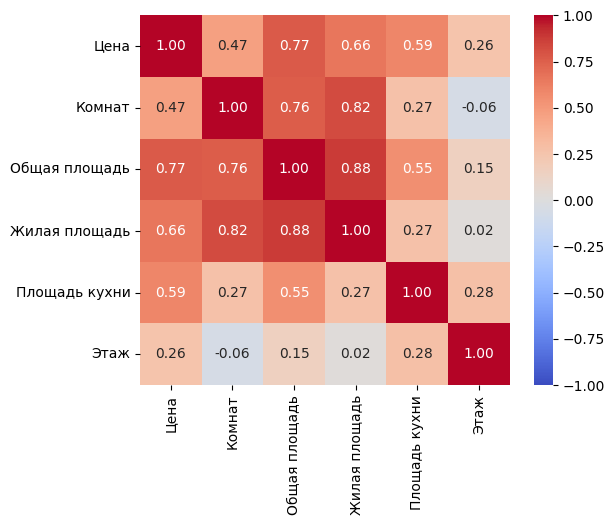

In [4039]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1
             , cmap='coolwarm'
            )
plt.show()

### 3. Обрабатываем пропущенные значения

Туда же строки с пропущенными значениями в категории "Материал стен"

In [4040]:
data_raw.dropna(subset=['Материал стен'], inplace=True)

In [4041]:
data_raw.isna().sum()

Цена             0
Район            0
Материал стен    0
Комнат           0
Общая площадь    0
Жилая площадь    0
Площадь кухни    0
Этаж             0
dtype: int64

Отлично! Пропущенных значений нет

### 4. Обработка признаков

In [4042]:
data_raw['Площадь'] = data_raw['Общая площадь']
data_raw.drop('Общая площадь', axis=1, inplace=True)

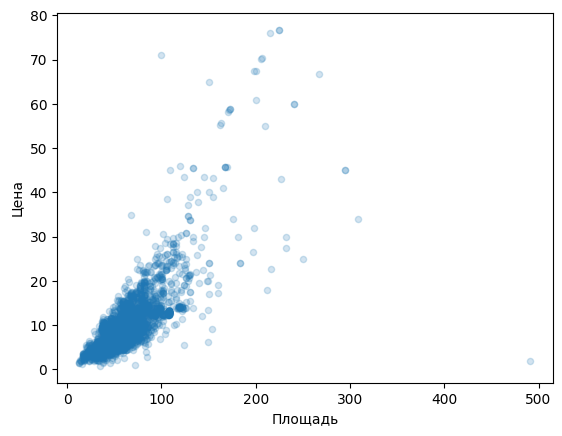

In [4043]:
data_raw.plot(kind = 'scatter', x = 'Площадь', y = 'Цена', alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-6)))
plt.show()

In [4044]:
rows_to_drop = data_raw[
    (data_raw['Цена'] > data_raw['Цена'].quantile(0.995)) |
    (data_raw['Площадь']  > data_raw['Площадь' ].quantile(0.995))].index
data_raw = data_raw.drop(rows_to_drop)
data_raw.shape

(3596, 8)

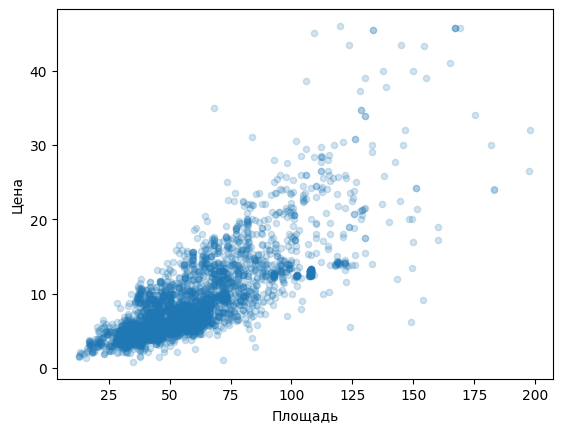

In [4045]:
data_raw.plot(kind = 'scatter', x = 'Площадь', y = 'Цена', alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-6)))
plt.show()

In [4046]:
data_raw['Цена'] = data_raw['Цена'] / 1000

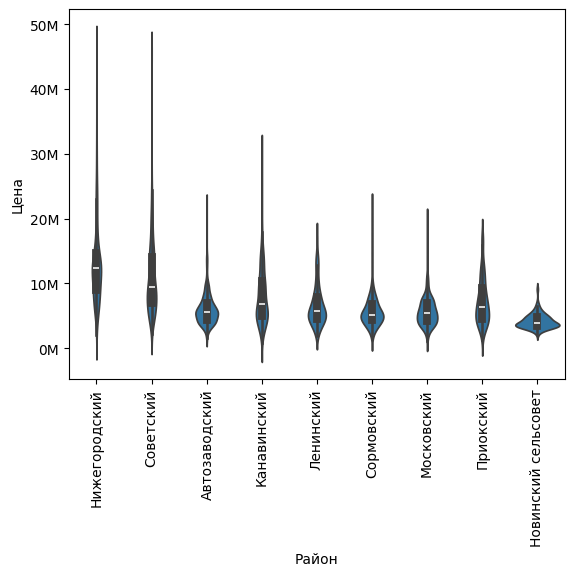

In [4047]:
sns.violinplot(x="Район", y="Цена", data=data_raw)
formatter = ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=90)
plt.show()
pass

In [4048]:
mapping = {
    'Новинский сельсовет': 1,
    'Автозаводский': 2,
    'Сормовский': 3,
    'Московский': 4,
    'Приокский': 5,
    'Канавинский': 6,
    'Ленинский': 7,
    'Советский': 8,
    'Нижегородский': 9,
}
data_raw['Район'] = data_raw['Район'].replace(mapping)
data_raw['Район'] = data_raw['Район'].astype(int)

**Заменим некоторые известные значения на эквивалентные им для возможности дальнейшего преобразования в известные типы**

In [4049]:
mapping = {
    'блок+утеплитель': 'блок',
    'поризованный керамический блок': 'блок',
    'кирпич, блок': 'кирпич',
    'шлакоблок': 'блок',
    'кирпич, панель': 'кирпич',
    'панель, кирпич': 'панель',
    'стеновая панель на деревянном каркасе': 'панель',
    'монолитный железобетон': 'монолит',
}
data_raw['Материал стен'] = data_raw['Материал стен'].replace(mapping)
data_raw['Материал стен'] = data_raw['Материал стен'].astype('category')

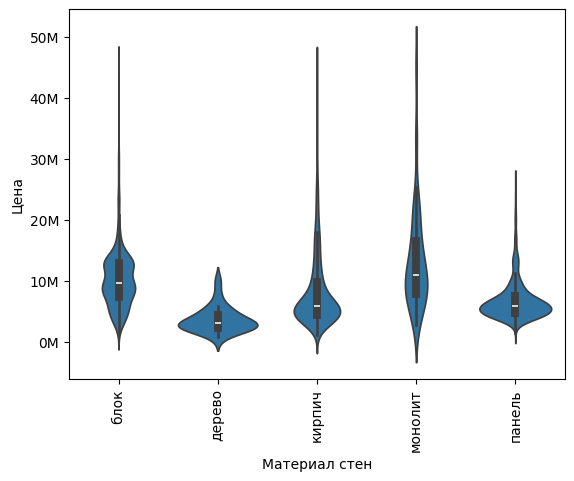

In [4050]:
sns.violinplot(x="Материал стен", y="Цена", data=data_raw)
formatter = ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=90)
plt.show()
pass

In [4051]:
mapping = {
    'дерево': 1,
    'панель' : 2,
    'кирпич' : 3,
    'блок' : 4,
    'монолит' : 5
}
data_raw['Материал стен'] = data_raw['Материал стен'].replace(mapping)
data_raw['Материал стен'] = data_raw['Материал стен'].astype(int)

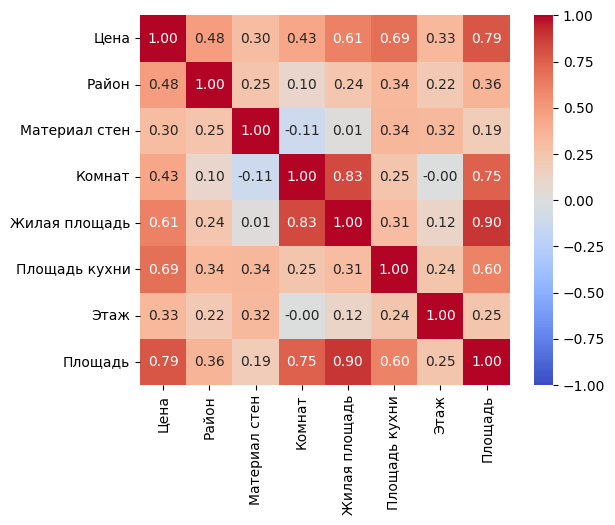

In [4052]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1
             , cmap='coolwarm'
            )
plt.show()

In [4053]:
data_raw.drop(['Жилая площадь', 'Площадь кухни'], axis=1, inplace=True)

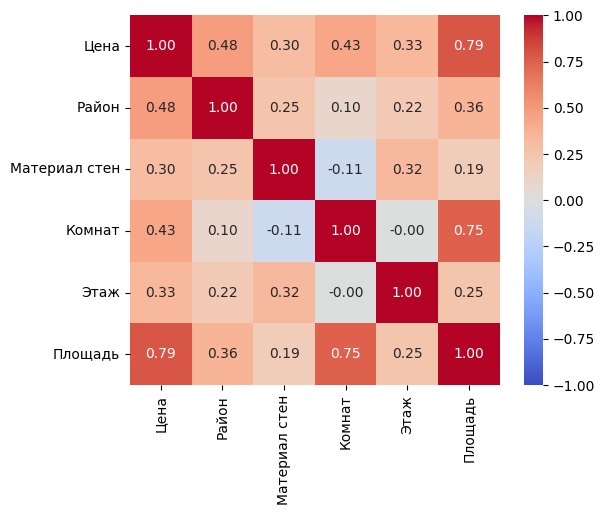

In [4054]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1
             , cmap='coolwarm'
            )
plt.show()

### 5. Проводим нормализацию

In [4055]:
X = data_raw.drop(['Цена'], axis=1)
y = data_raw['Цена']

In [4056]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

### 6. Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [4057]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(2697, 899)

### 7. Запуск классификатора ближайших соседей

In [4058]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=15)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [4059]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

### 8. Вычисление среднеквадратичной ошибки и коэффициента детерминации

In [4060]:
from sklearn.metrics import mean_squared_error, r2_score

In [4061]:
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
RMSE_test  = np.sqrt(mean_squared_error(y_test,  y_test_predict))

RMSE_table = pd.DataFrame(columns=('train', 'test'))
RMSE_table.loc['k Nearest Neighbours', :] = (RMSE_train, RMSE_test)

RMSE_table

,train,test
k Nearest Neighbours,2595.734214,2988.557638


In [4062]:
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)

R2_table = pd.DataFrame(columns=('train', 'test'))
R2_table.loc['k Nearest Neighbours', :] = (R2_train, R2_test)

R2_table

,train,test
k Nearest Neighbours,0.776068,0.747089


### Линейная регрессия (для справки)

In [4063]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [4064]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [4065]:
model.coef_

array([  920.29111004,   306.50178917, -1365.95029197,   269.08633934,
        4904.73020205])

In [4066]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [4067]:
LRMSE_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
LRMSE_test  = np.sqrt(mean_squared_error(y_test,  y_test_predict))
LR2_train = r2_score(y_train, y_train_predict)
LR2_test  = r2_score(y_test,  y_test_predict)

RMSE_table.loc['Linear Regression, all features', :] = (LRMSE_train, LRMSE_test)
R2_table.loc['Linear Regression, all features', :] = (LR2_train, LR2_test)

### Сравнение методов

In [4068]:
RMSE_table.loc['k Nearest Neighbours', :] = (RMSE_train, RMSE_test)
RMSE_table

,train,test
k Nearest Neighbours,2595.734214,2988.557638
"Linear Regression, all features",2985.298171,3139.638583


In [4069]:
R2_table.loc['k Nearest Neighbours', :] = (R2_train, R2_test)
R2_table

,train,test
k Nearest Neighbours,0.776068,0.747089
"Linear Regression, all features",0.70381,0.720872
